# OBJVAE

## Init

In [1]:
import os

import random, os
import numpy as np
import torch
import importlib
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

from objVAE import objVAE, MultiheadAttention
from objVAE import utils

def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

print(torch.cuda.is_available())

seed_everything(42)

True


### Helper functions

In [2]:
import deeptrack as dt
import numpy as np
import pytorch_lightning as pl
import matplotlib.pyplot as plt

image_size = 64

def run_test_old(model, combine_radius, plot_num=0, num_entities=10):
    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):
        gt_nodes = test_centroids[i_seq]

        # x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        x_hat, indices, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        x_hat = x_hat.detach().cpu().numpy()

        #n = [i for i_frame in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(mu.shape[0]):
            xy_mu = mu[i, :2].view(2, -1).detach().cpu().numpy()

            flatind = indices[i, :].detach().cpu().numpy()

            mu_obj = mu[i, :].view(mu.shape[1], -1)[:, flatind]

            xy = xy_mu[:, flatind]

            row, col = np.unravel_index(flatind, (16, 16))
            xp = (row + 0.5) * 4 - xy[0, :] * 2
            yp = (col + 0.5) * 4 - xy[1, :] * 2

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0)

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(mu.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                plt.subplot(1, 2, 2)
                plt.imshow(x_hat[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i] * 1000
            yp_filtred = yp + remove_map_v[i] * 1000

            distances = distance_matrix(
                np.array([xp_filtred / image_size, yp_filtred / image_size]),
                gt_nodes_timestep,
            )
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                last_mapping = min_distance
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            tp = np.sum(gt_attention.astype(bool) & binary_attention.astype(bool))
            fp = np.sum(binary_attention.astype(bool)) - tp
            tn = np.sum(
                ~gt_attention.astype(bool) & ~binary_attention.astype(bool)
            )
            fn = np.sum(~binary_attention.astype(bool)) - tn

            mse_total.append(mse)
            false_detections_total.append(
                false_detections / (false_detections + true_detections)
            )
            missed_detections_total.append(missed_detections / (min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.argmax(binary_attention, axis=1)
                for i_prev, i_curr in enumerate(cols):
                    if remove_map_v[i - 1][i_prev] or remove_map_v[i][i_curr]:
                        continue
                    x_line = [xp_v[i - 1][i_prev], xp_v[i][i_curr]]
                    y_line = [yp_v[i - 1][i_prev], yp_v[i][i_curr]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean / (tp_mean + fp_mean)
    recall = tp_mean / (tp_mean + fn_mean)

    f1 = 2 * precision * recall / (precision + recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }

def combine_nodes(attention_to_next, combine_map_v, remove_map_v, i_combine):
    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine]):
        attention_to_next_dt = attention_to_next.detach().cpu().numpy()
        #new_attention_row = attention_to_next_dt
        new_attention_row = np.transpose(np.transpose(attention_to_next_dt) * row)
        new_attention_row = np.sum(new_attention_row, axis = 0)/np.sum(row)
        if remove_map_v[i_combine][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(new_attention)

    updated_attention = new_attention

    new_attention = []
    for j, row in enumerate(combine_map_v[i_combine+1]):
        attention_to_next_dt = updated_attention
        new_attention_row = attention_to_next_dt * row
        new_attention_row = np.sum(new_attention_row, axis = 1)/np.sum(row)
        if remove_map_v[i_combine+1][j]:
            new_attention_row *= 0
        new_attention.append(new_attention_row)
    new_attention = np.array(np.transpose(new_attention))
    return new_attention

def distance_matrix(matrix_a, matrix_b):
    expanded_a = np.expand_dims(matrix_a, 1)  # Shape: (n, 1, m)
    expanded_b = np.expand_dims(matrix_b, 0)  # Shape: (1, n, m)
    expanded_a = np.transpose(expanded_a, (2, 1, 0))
    square_difference = np.square(
        expanded_a - expanded_b
    )  # Element-wise squared difference
    distances = np.sum(square_difference, axis=2)
    distances = np.sqrt(distances)
    return distances

def distance(x1, x2, y1, y2):
    dist = np.sqrt(np.square(x1 - x2) + np.square(y1-y2))
    return dist

def run_test(model, combine_radius, plot_num=0, num_entities=10, pres_floor=0.25, tra_floor=0.25):
    mse_total = []
    false_detections_total = []
    missed_detections_total = []
    tp_total = []
    fp_total = []
    tn_total = []
    fn_total = []
    for i_seq, x in enumerate(test):
        gt_nodes = test_centroids[i_seq]

        # x = x[1:2]
        x = torch.unsqueeze(x, dim=0)
        x = x.to(model.device)
        recon, indices, pres, kl_divergence, xy_pred, mu, logvar, attention, xy = model(x)

        x = x.detach().cpu().numpy()
        recon = recon.detach().cpu().numpy()
        pres = pres.detach().cpu().numpy()
        xy = xy.detach().cpu().numpy()

        n = [i for i in range(num_entities)]

        combine_map_v = []
        remove_map_v = []
        xp_v = []
        yp_v = []
        for i in range(xy.shape[0]):

            xp = xy[i, :, 0]
            yp = xy[i, :, 1]

            xp_v.append(xp)
            yp_v.append(yp)

            if i_seq == plot_num:
                plt.figure(figsize=(10, 10))

            distances = []
            for j in range(xp.shape[0]):
                distance_r = []
                for k in range(xp.shape[0]):
                    if j == k:
                        distance_r.append(0)
                        continue
                    dist = distance(xp[j], xp[k], yp[j], yp[k])
                    distance_r.append(dist)
                distances.append(distance_r)
            distances = np.array(distances)

            # Create the combin map
            row_indices, col_indices = np.indices(distances.shape)
            matrix = np.zeros(distances.shape)
            matrix[row_indices - col_indices <= 0] = 1

            combine_map = (
                np.where(np.array(distances) < combine_radius, 1, 0).astype(bool)
                & matrix.astype(bool)
            ).astype(np.int32)

            pres_mask = pres[i] <= pres_floor

            remove_map = np.sum(combine_map - np.eye(combine_map.shape[0]), axis=0) + pres_mask

            combine_map_v.append(combine_map)
            remove_map_v.append(remove_map)

        for i in range(xy.shape[0]):
            xp = xp_v[i]
            yp = yp_v[i]
            gt_nodes_timestep = np.array(gt_nodes[i])

            if i_seq == plot_num:
                if i > 0:
                    scatter.remove()
                    show.remove()
                    for ann in annotations:
                        ann.remove()
                plt.subplot(1, 2, 1)

                show = plt.imshow(x[0, i, 0, :, :], cmap="gray")
                # plt.colorbar()
                scatter = plt.scatter(
                    yp[~remove_map_v[i].astype(bool)],
                    xp[~remove_map_v[i].astype(bool)],
                    marker="o",
                    s=300,
                    edgecolor="r",
                    facecolor="none",
                )
                annotations = []
                for j, txt in enumerate(n):
                    if remove_map_v[i][j]:
                        continue
                    annotations.append(
                        plt.annotate(
                            round(pres[i, j], 3), (yp[j], xp[j]), color="white"
                        )
                    )
                plt.subplot(1, 2, 2)
                plt.imshow(recon[0, i, 0, :, :], cmap="gray")
                # plt.scatter(gt_nodes_timestep[:,1]*image_size, gt_nodes_timestep[:,0]*image_size, color='g')

            # Calculate node metrics
            xp_filtred = xp + remove_map_v[i] * 1000
            yp_filtred = yp + remove_map_v[i] * 1000

            distances = distance_matrix(
                np.array([xp_filtred / image_size, yp_filtred / image_size]),
                gt_nodes_timestep,
            )
            min_distance = np.argmin(distances, axis=0)
            min_distance_2 = np.argmin(distances, axis=1)

            tn = 0
            tps = []
            missed_detections = 0
            false_detections = 0
            true_detections = 0
            for i_dist, dist_1 in enumerate(min_distance):
                if i_dist == min_distance_2[dist_1]:
                    tps.append(i_dist)
                else:
                    missed_detections += 1

            for i_dist, dist_2 in enumerate(min_distance_2):
                if remove_map_v[i][i_dist]:
                    continue
                if i_dist == min_distance[dist_2]:
                    true_detections += 1

                else:
                    false_detections += 1

            se = np.min(distances, axis=0)[tps]
            mse = np.mean(se)

            # Calculate attention metrics
            if i == 0:
                if i_seq == plot_num:
                    plt.savefig(f"../results/gif/fig_{i}.png")
                last_mapping = min_distance
                continue

            attention_to_next = attention[
                0,
                (i - 1) * num_entities : i * num_entities,
                i * num_entities : (i + 1) * num_entities,
            ]
            new_attention = combine_nodes(
                attention_to_next, combine_map_v, remove_map_v, i - 1
            )

            if i_seq == plot_num:
                print(new_attention)

            gt_attention = np.zeros_like(new_attention)
            gt_attention[last_mapping, min_distance] += 1

            max_indices = np.argmax(new_attention, axis=1)
            binary_attention = np.zeros_like(new_attention)
            binary_attention[np.arange(new_attention.shape[0]), max_indices] = 1
            binary_attention *= np.where(new_attention > 0, 1, 0)

            binary_attention *= np.where(new_attention >= tra_floor, 1, 0)

            tp = np.sum(gt_attention.astype(bool) & binary_attention.astype(bool))
            fp = np.sum(binary_attention.astype(bool)) - tp
            tn = np.sum(
                ~gt_attention.astype(bool) & ~binary_attention.astype(bool)
            )
            fn = np.sum(~binary_attention.astype(bool)) - tn

            mse_total.append(mse)
            if (false_detections + true_detections):
                false_detections_total.append(
                    false_detections / (false_detections + true_detections)
                )
            missed_detections_total.append(missed_detections / (min_distance.shape[0]))

            tp_total.append(tp)
            fp_total.append(fp)
            tn_total.append(tn)
            fn_total.append(fn)

            last_mapping = min_distance

            if i_seq == plot_num:
                plt.subplot(1, 2, 1)
                cols = np.where(binary_attention == 1)
                #cols = np.argmax(binary_attention, axis=1)
                for i_col, _ in enumerate(cols[0]):
                    previous = cols[0][i_col]
                    current = cols[1][i_col]
                    if remove_map_v[i - 1][previous] or remove_map_v[i][current]:
                        continue
                    x_line = [xp_v[i - 1][previous], xp_v[i][current]]
                    y_line = [yp_v[i - 1][previous], yp_v[i][current]]

                    plt.plot(y_line, x_line, c="b")

                plt.savefig(f"../results/gif/fig_{i}.png")

    mae_mean = np.mean(np.array(mse_total))
    fd_mean = np.mean(np.array(false_detections_total))
    md_mean = np.mean(np.array(missed_detections_total))

    tp_mean = np.mean(np.array(tp_total))
    fp_mean = np.mean(np.array(fp_total))
    tn_mean = np.mean(np.array(tn_total))
    fn_mean = np.mean(np.array(fn_total))

    precision = tp_mean / (tp_mean + fp_mean)
    recall = tp_mean / (tp_mean + fn_mean)

    f1 = 2 * precision * recall / (precision + recall)

    return {
        "mae_mean": mae_mean,
        "fd_mean": fd_mean,
        "md_mean": md_mean,
        "precision": precision,
        "recall": recall,
        "f1-score": f1,
    }
def update_position(previous_value, diffusion_constant, dt=1 / 10):
    new_position = np.clip(
        previous_value + np.random.randn(2) * np.sqrt(diffusion_constant * dt) * 1e7,
        0+5,
        image_size-5,
    )
    return new_position


def get_positions(image):
    # All properties are stored in the `properties` field of the output.
    positions = image.get_property("position", get_one=False)
    return np.array(positions) / image_size


def generate_data(sequence_length, data_amount=1000, noise_mu=0.0, noise_sigma=0.1):
    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6 / 2, 1e-6 * 2),
        z=0 * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
        
    )
    '''
    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: (np.random.binomial(1, 0.5)/10 + 1)*2 * 1e-6,
        z=0 * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )
    '''

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    # %%
    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2, 6))
    image_pipeline = optics(particles) >> dt.Gaussian(mu=noise_mu, sigma=noise_sigma)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    image_pipeline.update().plot()

    # generate a dataset of 1000 images
    print("Generating Training data")
    images = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)
        images.append(image_pipeline.update()())

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)
    print(tensors.shape)
    # make channel first
    tensors = tensors.permute(0, 1, 4, 2, 3)
    train_set, test_set = torch.utils.data.random_split(
        tensors, [int(data_amount * 0.8), int(data_amount * 0.2)]
    )

    test, test_centroids, test_edges = generate_test_data(int(data_amount*0.1), sequence_length)

    return train_set, test_set, test, test_centroids, test_edges

def generate_test_data(data_amount, sequence_length, noise_mu=0, noise_sigma=0.1):
    print("Generating Test data")

    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-12,
        refractive_index=1.55,
        radius=lambda: np.random.uniform(1e-6 / 2, 1e-6 * 2),
        z=0 * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )
    
    """
    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=lambda: (np.random.binomial(1, 0.5)*3 + 1) * 1e-6,
        z=0 * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )
    """
    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ 2#(lambda: np.random.randint(2,8))
    image_pipeline = optics(particles) >> dt.Gaussian(mu=noise_mu, sigma=noise_sigma)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)

        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)

            if i == len(images):
                break

            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)

        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return test, test_centroids, test_edges


def make_dataloaders(train_set, test_set, batch_size=16, num_workers=0):
    # create dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False,  num_workers=num_workers)
    return train_loader, test_loader


def plot_training(model, test_loader, presence=True, trainer=''):
    # forwards pass
    # model.eval()
    x = next(iter(test_loader))
    x = x[:1]
    x = x.to(model.device)

    if presence:
        recon, indices, pres, kl_divergence, pres_loss, delta_xy_pred, mu, logvar, attention, xy = model(x)
        alpha = pres[0].detach().cpu().numpy() > 0.25
        xy = xy.detach().cpu().numpy()[0, alpha]
        edge_color = plt.cm.get_cmap('spring')(pres[0, alpha].detach().cpu().numpy())

    else:
        recon, indices, kl_divergence, delta_xy_pred, mu, logvar, attention, xy = model(x)
        xy = xy.detach().cpu().numpy()[0, :]
        edge_color = 'r'


    plt.figure(figsize=(20, 20))
    plt.subplot(1, 2, 1)
    plt.imshow(x[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")
    
    plt.scatter(xy[:, 1], xy[:, 0], marker="o", s=300, edgecolors=edge_color, facecolor="none")
    
    plt.title("Input image")
    
    plt.subplot(1, 2, 2)
    plt.imshow(
        recon[0, 0, 0, :, :].detach().cpu().numpy(),
        vmin=x[0, 0, 0, :, :].min(),
        vmax=x[0, 0, 0, :, :].max(),
        cmap="gray",
    )
    plt.title("Reconstruction")
    if trainer:
        if trainer.current_epoch % 50 == 0:
            plt.savefig(f"../results/training/fig_{trainer.current_epoch}.png")

    return plt

/home/gideon/Documents/PhD/Projects/Objvae/.venv/lib/python3.11/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/home/gideon/Documents/PhD/Projects/Objvae/.venv/lib/python3.11/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
2024-04-10 11:41:14.678489: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-10 11:41:14.807929: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 11:41:14.807985: E external/local

## Run/Test

### Generate data

Generating Training data
0
torch.Size([100, 5, 64, 64, 1])
Generating Test data
0


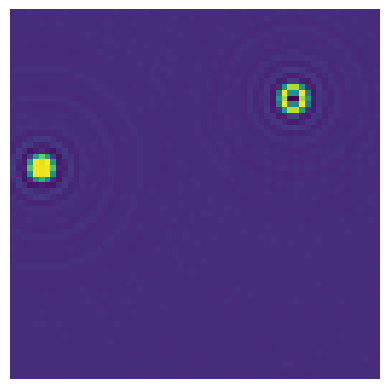

In [3]:
seqeunce_length = 5
data_amount = 100
batch_size = 16
noise_mu = 0.0
noise_sigma = 0.0

train_set, test_set, test, test_centroids, test_edges = generate_data(
    sequence_length=seqeunce_length,
    data_amount=data_amount,
    noise_mu=noise_mu,
    noise_sigma=noise_sigma
)

In [4]:
print(train_set[0].min())

tensor(-0.4961)


In [4]:
num_workers = 0
batch_size = 4

train_loader, test_loader = make_dataloaders(train_set, test_set, batch_size=batch_size, num_workers=num_workers)

### Create model

In [9]:
importlib.reload(objVAE)
importlib.reload(MultiheadAttention)

import IPython.display as ipd

# Callbacks
max_steps = 20000
beta_annealing_end = 1000
lr_annealing_end = max_steps
kl_annealing_end = 2400 # 2400
presence_annealing_end = 1000

def beta_annealing(step):
    #logs = np.logspace(-4, -2.5, beta_annealing_end) # 8.3 - 7
    lins = np.linspace(1, 0, beta_annealing_end)
    if step < beta_annealing_end:
        return lins[step]#logs[int(step)]
    else:
        return 0#logs[-1]
    
def kl_annealing(step):
    logs = np.linspace(0, 1, kl_annealing_end)
    if step < 500:
        return 0
    if step < kl_annealing_end:
        return 0#logs[step]
    else:
        return 0#1

def presence_annealing(step):
    lins = np.linspace(0, 1, presence_annealing_end)
    if step < presence_annealing_end:
        return 0#lins[step]
    else:
        return 0
    
def lr_annealing(step):
    logs = np.logspace(-3, -5, lr_annealing_end)
    
    if step < lr_annealing_end:
        return logs[step]
    else:
        return logs[-1]


class AnCallbacks(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        step = trainer.global_step
        pl_module.model.beta = beta_annealing(step)
        pl_module.model.presence_bias = presence_annealing(step)
        pl_module.optimizers().lr = lr_annealing(step)
        pl_module.model.kl_importance = kl_annealing(step)


class PlotCallback(pl.Callback):
    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % 10:
            return
        ipd.clear_output(wait=True)
        plot_training(model, test_loader, presence=True, trainer=trainer)
        plt.suptitle(f"Epoch {trainer.current_epoch}")
        plt.show()


load_model = ""

#load_model = "../state_dicts/model-pca-test.pth"
#load_model = "../state_dicts/model-MP-firstworking.pth"

# General model settings
num_entities = 10
latent_dim = 5
beta = 1e-4
object_radius = 8
combine_method = "sum"
topk_select_method = 'max'


# Encoder settings
encoder_pooling_layers=3
encoder_layers=1

# Decoder settings
single_decoder = True
decoder="linear"
decoder_feature_size=56 #56
decoder_num_layers=4

# Attention settings
use_attention = False
softmax_tmp = 1
attention_mechanism='euclidean'
number_of_heads = 1
max_t = 1
pos_attention_weight = 1

attention = MultiheadAttention.MultiheadAttention(
    max_t=max_t, attention_mechanism=attention_mechanism, softmax_factor=softmax_tmp, number_of_heads=number_of_heads, num_filters=latent_dim-2, pos_attention_weight=pos_attention_weight
)

model = objVAE.MEVAE(
    num_entities,
    attention_model=attention,
    beta=beta,
    latent_dim=latent_dim,
    attention=use_attention,
    glimpse_size=object_radius,
    combine_method=combine_method,
    topk_select_method=topk_select_method,
    single_decoder = single_decoder,
    decoder=decoder,
    decoder_feature_size = decoder_feature_size,
    encoder_pooling_layers=encoder_pooling_layers,
    encoder_conv_layers=encoder_layers,
    decoder_num_layers=decoder_num_layers
)


if load_model:
    model.load_state_dict(torch.load(load_model))


### Train

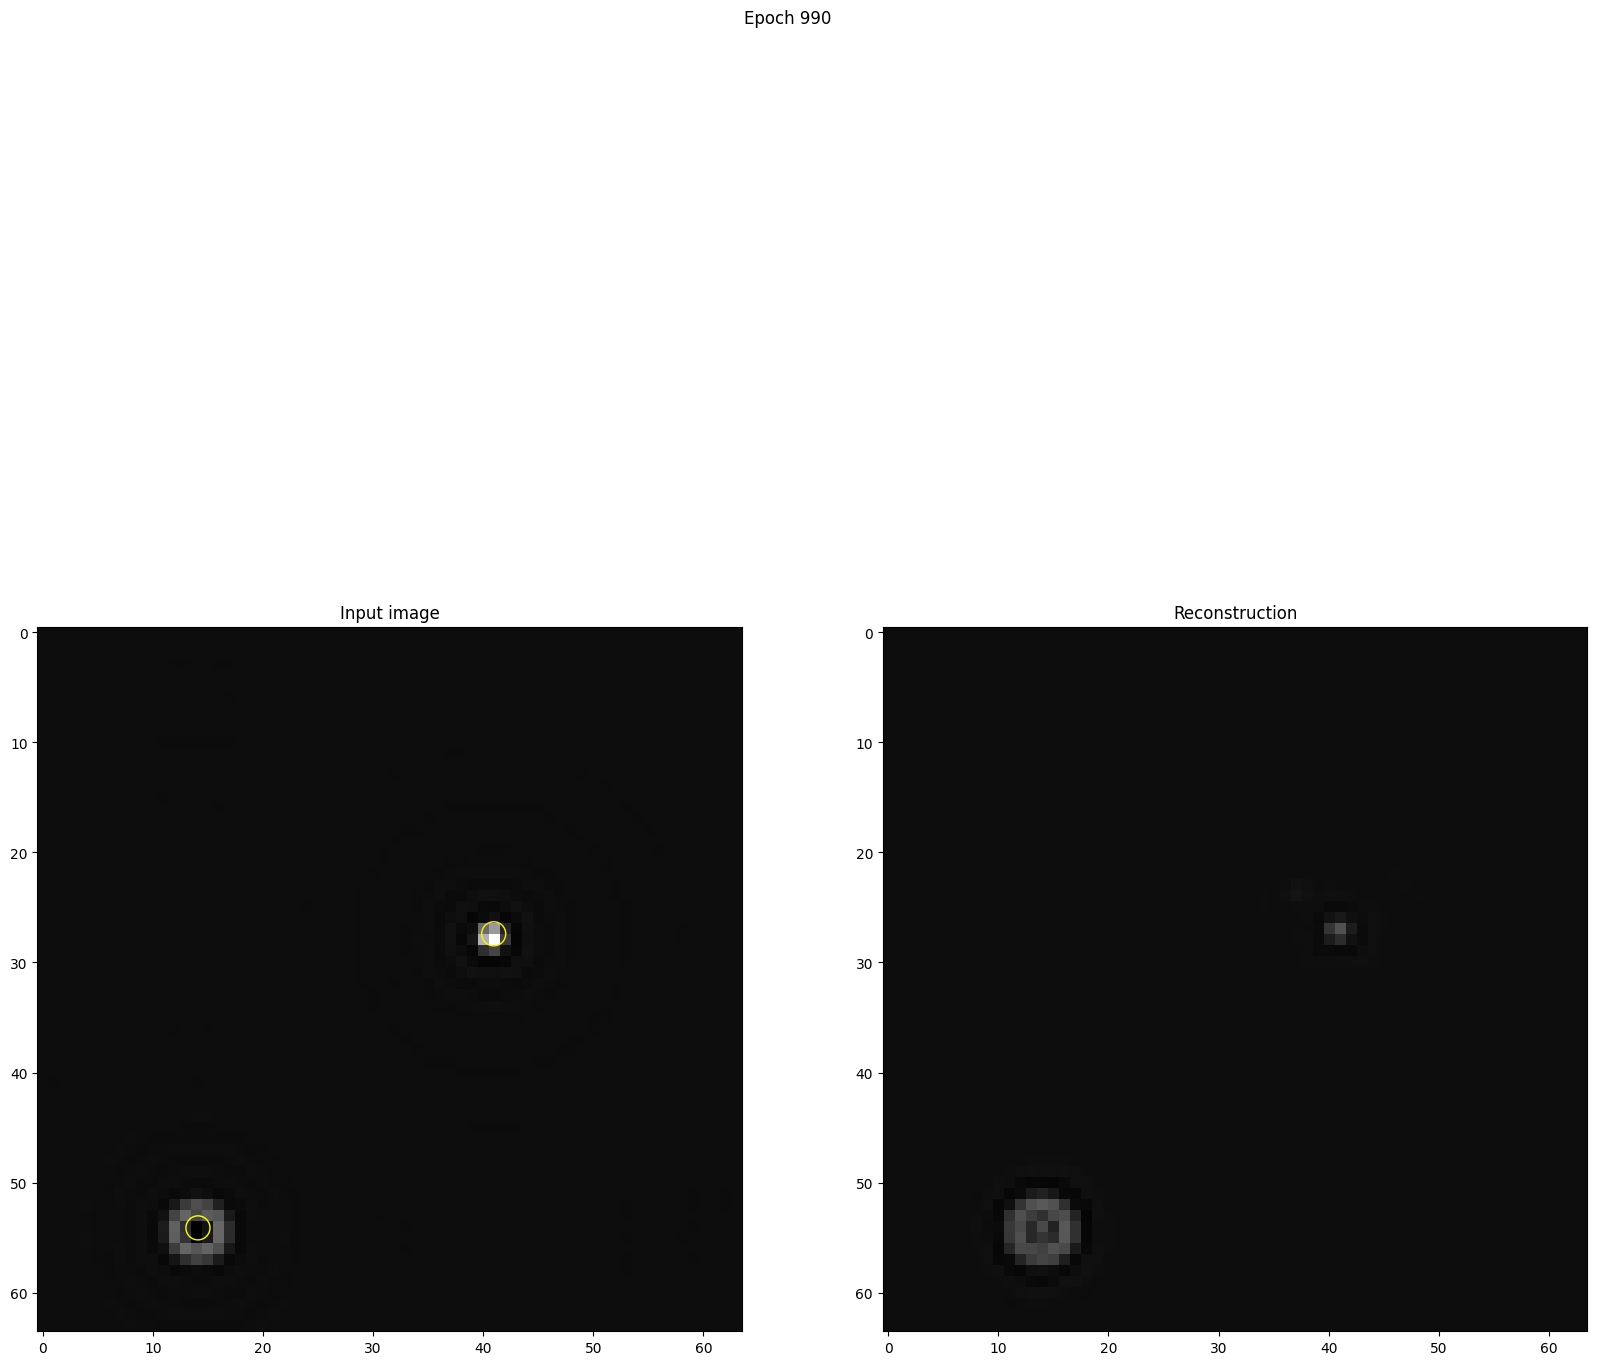

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=20000` reached.


In [10]:
trainer = pl.Trainer(max_steps=max_steps, callbacks=[AnCallbacks(), PlotCallback()])
trainer.fit(model, train_loader, test_loader)

### Test

In [15]:
test, test_centroids, test_edges = generate_test_data(5, 50, noise_mu=0, noise_sigma=0.0)

Generating Test data
0


In [47]:
seq = test[2]

tra_list = model.extract_obj_and_tra(seq, 1, presence_floor=0.25)

print('...........')
plt.imshow(seq[-1][0], cmap='gray')
for i, dict in enumerate(tra_list):
    print(dict)
    plt.plot(dict.get('y'), dict.get('x'), '-o')
plt.show()

ValueError: too many values to unpack (expected 9)

/home/gideon/Documents/PhD/Projects/Objvae/objVAE/objVAE/utils.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(20, 10))


KeyboardInterrupt: 

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

<Figure size 2000x1000 with 0 Axes>

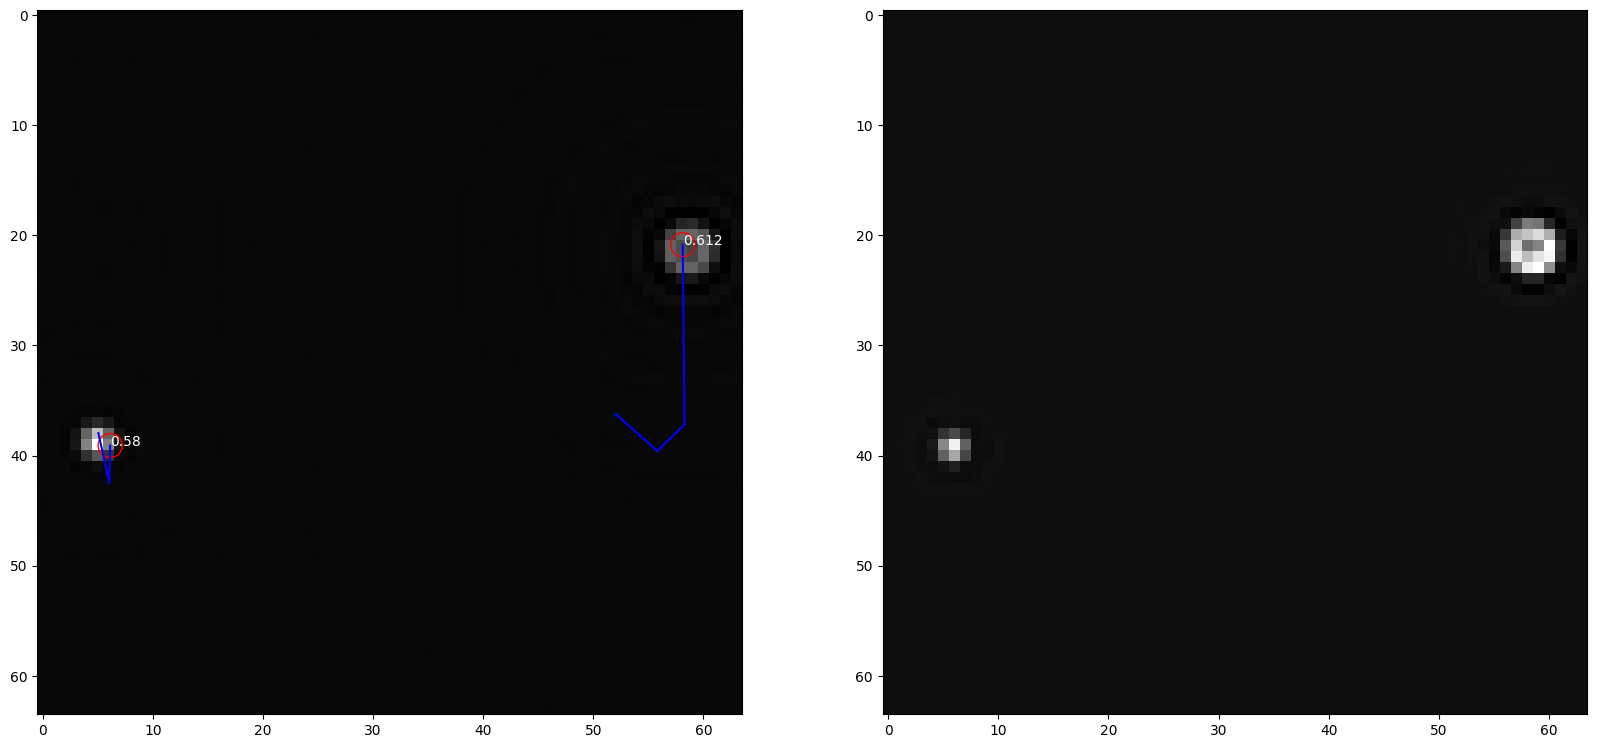

In [33]:
metrics = utils.run_test(test, model, 4, num_entities=10, plot_num=1, pres_floor=0.25, tra_floor=0.01)
#metrics = run_test_old(model, 3, num_entities=10, plot_num=10)

print(metrics)

### Save model

In [ ]:
torch.save(model.state_dict(), "../state_dicts/model-pca-test.pth")

: 

### PCA

#### Generate data

In [ ]:
def generate_pca_data(data_amount, sequence_length, radius):
    print("Generating Test data")

    image_size = 64

    particle = dt.MieSphere(
        diffusion_constant=(1 + np.random.rand() * 9) * 1e-13,
        refractive_index=1.55,
        radius=(radius*3 + 1) * 1e-6,
        z=0 * dt.units.um,
        position=lambda: np.random.uniform(5, image_size - 5, 2),
    )

    optics = dt.Brightfield(
        NA=0.4,
        magnification=5,
        resolution=3e-6,
        wavelength=0.6e-6,
        output_region=(0, 0, image_size, image_size),
    )

    particle = dt.Sequential(particle, position=update_position)
    particles = particle ^ (lambda: np.random.randint(2,8))
    image_pipeline = optics(particles) >> dt.Gaussian(mu=0, sigma=0)

    image_pipeline = dt.Sequence(image_pipeline, sequence_length=sequence_length)

    test_images = []
    test_centroids = []
    test_edges = []
    for i in range(data_amount):
        if i % 100 == 0:
            print(i)

        images = image_pipeline.update()()
        test_images.append(images)
        edges_image = []
        nodes = []
        for i, image in enumerate(images):
            positions = get_positions(image)
            nodes.append(positions)

            if i == len(images):
                break

            edges = []
            for j, _ in enumerate(positions):
                edges.append([j, j])
            edges_image.append(edges)

        test_centroids.append(nodes)
        test_edges.append(np.array(edges_image))

    # convert to tensor
    tensors = torch.tensor(np.array([i for i in test_images])).float() - 1
    # tensors = tensors.repeat(1, 3, 1, 1, 1)

    # make channel first
    test = tensors.permute(0, 1, 4, 2, 3)

    return test, test_centroids, test_edges

def pca(latents):

    # subtract mean from data in order to do mean centering
    mean = np.mean(latents, axis=0)
    centered_latents = latents - mean

    # Compute the covariance matrix
    cov_matrix = np.cov(centered_latents, rowvar=False)
    cov_matrix = np.round(cov_matrix, 2)

    # Compute eighenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort the eigenvalues and eigenvectors in descending order
    indices = np.arange(0,len(eigenvalues), 1)
    indices = ([x for _,x in sorted(zip(eigenvalues, indices))])[::-1]
    eigenvalues = eigenvalues[indices]
    eigenvectors = eigenvectors[:,indices]

    explained_variance = eigenvalues / np.sum(eigenvalues)
    cumulative_explained_variance = np.cumsum(explained_variance)
    print("Cumulative explained variance: ", cumulative_explained_variance)
    
    pca_data = np.dot(centered_latents, eigenvectors)

    return pca_data, cumulative_explained_variance


In [ ]:
dataset_small,_,_ = generate_pca_data(50, 20, 0)
dataset_large,_,_ = generate_pca_data(50, 20, 1)
    

Generating Test data
0
Generating Test data
0


KeyboardInterrupt: 

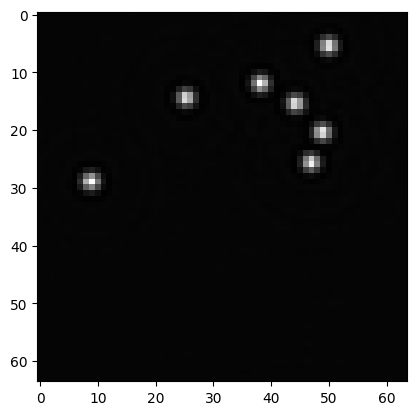

In [ ]:
plt.imshow(dataset_small[0, 0, 0, :, :].detach().cpu().numpy(), cmap="gray")

In [ ]:
latents_small, new_latents_small, pres_small = model.model.extract_latents(dataset_small)

presence_small = (torch.squeeze(pres_small) > 0.25)

latents_small = latents_small.view(-1, 8)
new_latents_small = new_latents_small.view(-1, 8)
presence_small = presence_small.view(-1)

latents_small = latents_small.detach().cpu().numpy()
new_latents_small = new_latents_small.detach().cpu().numpy()
presence_small = presence_small.detach().cpu().numpy()

latents_small = latents_small[presence_small, :]
new_latents_small = new_latents_small[presence_small, :]

print(latents_small.shape)
print(new_latents_small.shape)
print(presence_small.shape)

color_small = np.ones((latents_small.shape[0]))*1

RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
latents_large, new_latents_large, pres_large = model.model.extract_latents(dataset_large)

presence_large = (torch.squeeze(pres_large) > 0.25)

latents_large = latents_large.view(-1, 8)
new_latents_large = new_latents_large.view(-1, 8)
presence_large = presence_large.view(-1)


latents_large = latents_large.detach().cpu().numpy()
new_latents_large = new_latents_large.detach().cpu().numpy()
presence_large = presence_large.detach().cpu().numpy()

latents_large = latents_large[presence_large, :]
new_latents_large = new_latents_large[presence_large, :]

print(latents_large.shape)
print(new_latents_large.shape)
print(presence_large.shape)

color_large = np.ones((latents_large.shape[0]))*2

(7918, 3)
(7918, 3)
(10000,)


In [ ]:
colors = np.concatenate((color_small, color_large))
latents = np.concatenate((latents_small, latents_large))
new_latents = np.concatenate((new_latents_small, new_latents_large))

Cumulative explained variance:  [0.42765277 0.83349749 1.        ]


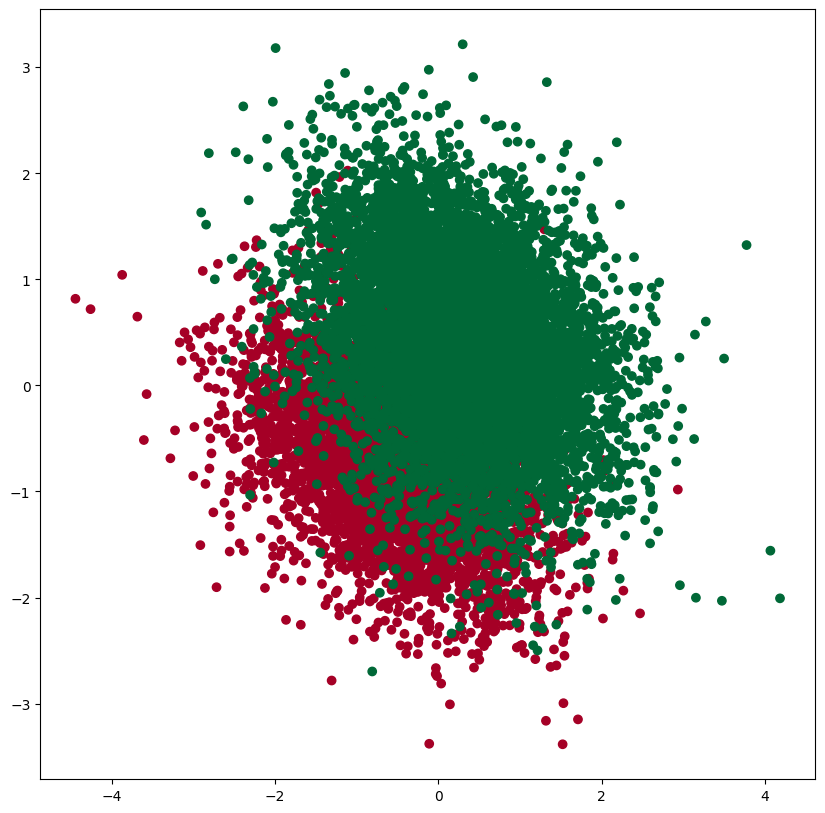

In [ ]:
plt.figure(figsize=(10, 10))
pca_data, _ = pca(latents)
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=colors, cmap='RdYlGn')

Cumulative explained variance:  [0.43055556 0.8389201  1.        ]


/tmp/ipykernel_281891/3017414736.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(pca_data[:, 0], pca_data[:, 1], cmap='RdYlGn')


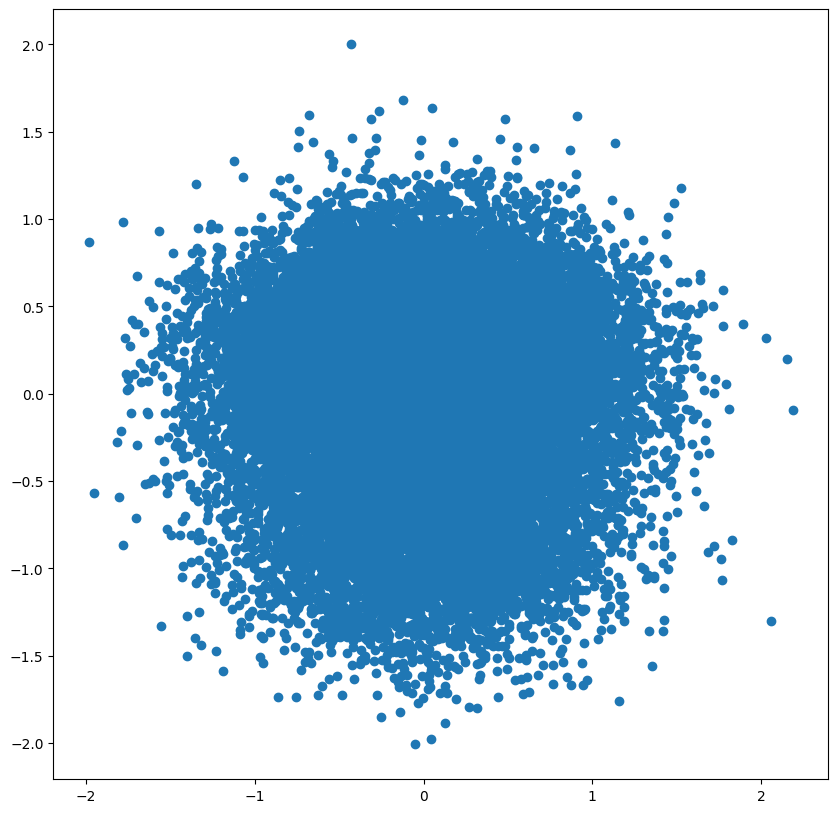

In [ ]:
plt.figure(figsize=(10, 10))
pca_data, _ = pca(new_latents_small)
plt.scatter(pca_data[:, 0], pca_data[:, 1], cmap='RdYlGn')

### PCA Interactive

In [11]:
latents, new_latents, pres, coords = model.model.extract_latents(test[:2].to(model.device))
print(test.shape)
presence = (torch.squeeze(pres) > 0.25).to(torch.int32)

new_latents = new_latents[:, :, :]
#new_latents = torch.unsqueeze(new_latents, axis=1)
print(new_latents.shape)

coords = coords.view(-1,2).detach().cpu().numpy()
new_latents_detached = new_latents.view(-1, 3).detach().cpu().numpy()
presence = presence.view(-1).detach().cpu().numpy()

torch.Size([5, 50, 1, 64, 64])
torch.Size([100, 10, 3])


In [12]:
def reconstruct(index):
    x_range = torch.arange(-test.shape[3]/2, test.shape[3]/2, device=latents.device, dtype=torch.float32)
    y_range = torch.arange(-test.shape[4]/2, test.shape[4]/2, device=latents.device, dtype=torch.float32)
    x_grid, y_grid = torch.meshgrid(torch.squeeze(x_range), torch.squeeze(y_range))

    grid_channel = torch.stack([x_grid, y_grid], dim=-1).view(1, 1, -1, 2)
    grid_channel = grid_channel.repeat(new_latents.shape[0]*1, 1, 1, 1)

    images = model.model.decode_from_latents(torch.unsqueeze(new_latents[:, index[0]%new_latents.shape[1], :], axis=1), (test.shape[3], test.shape[4]), grid_channel)
    images = images.detach().cpu().numpy()

    return images[index[0]//new_latents.shape[1]]
    
    

def update_point(trace, points, selector):
    if not points.point_inds:
        return
    fig.data = [fig.data[0]]
    
    recon_image = np.squeeze(reconstruct(points.point_inds))
    fig.add_trace(px.imshow(recon_image, color_continuous_scale='gray').data[0], row=1, col=2)

    ind = points.point_inds[0]//new_latents.shape[1]
    input_image = np.squeeze(test[ind//test.shape[1], ind%test.shape[1], 0, :, :])
    fig.add_trace(px.imshow(input_image, color_continuous_scale='gray').data[0], row=2, col=2)
    fig.add_trace(go.Scatter(x=[coords[points.point_inds[0], 1]], y=[coords[points.point_inds[0], 0]], mode="markers", marker_size=30, marker_symbol='circle-open', marker_line_width=4), row=2, col=2)




In [13]:
import plotly.graph_objects as go
import plotly.express as px
from plotly import subplots

pca_data, _ = utils.pca(new_latents_detached[:,:])
print(new_latents_detached.shape)

x = pca_data[:,0]
y = pca_data[:,1]

color0 = np.zeros((new_latents_detached.shape[0]//test.shape[1]))
color1 = np.ones((new_latents_detached.shape[0]//test.shape[1]))

color = np.concatenate((color0, color1))

fig = go.FigureWidget(subplots.make_subplots(rows=2, cols=2))

#fig.add_scatter(x=x, y=y, mode='markers')
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', marker_opacity=presence, marker_size=10, marker_line_width=1), row=1, col=1)
scatter = fig.data[0]
scatter.on_click(update_point)

fig.layout.title = 'PCA'
fig.layout.xaxis.title = 'PC1'
fig.layout.yaxis.title = 'PC2'
fig.layout.hovermode = 'closest'
fig.layout.width = 1200
fig.layout.height = 1200
fig.update_coloraxes(colorscale='gray')


fig

Cumulative explained variance:  [0.76267416 0.95298767 1.        ]
(1000, 3)


FigureWidget({
    'data': [{'marker': {'line': {'width': 1},
                         'opacity': array([1, 1, 0, ..., 0, 0, 1], dtype=int32),
                         'size': 10},
              'mode': 'markers',
              'type': 'scatter',
              'uid': '8d6d0a45-a2d6-472d-a3e7-392ddb800879',
              'x': array([-0.47078403, -0.29348519, -1.20810641, ..., -0.44888663, -1.68771041,
                           1.32769012]),
              'xaxis': 'x',
              'y': array([-1.20445071, -1.21146146,  1.78966426, ...,  0.54441337,  1.8775869 ,
                          -0.6479987 ]),
              'yaxis': 'y'}],
    'layout': {'coloraxis': {'colorscale': [[0.0, 'rgb(0, 0, 0)'],
                                            [0.09090909090909091, 'rgb(16, 16,
                                            16)'], [0.18181818181818182, 'rgb(38,
                                            38, 38)'], [0.2727272727272727,
                                            'rgb(59, 59,